Shiqi Wang 

shiwang@scripps.edu

Ran Lab, Scripps Research

Created: March 2024

Modified: December 25 2024

Archived: August 2025

# MAPseq data analysis

## Data preparation

In [ ]:
# Matrix Information
# barcodematrix: raw barcode counts before filtering; 
#                 rows represent barcodes and columns represent areas. 
#  refbarcodes: all barcode sequences, rows correspond to rows in barcodematrix.
#  spikes: spike-in counts. Each correspond to one column in barcodematrix.
#  Bn: filtered barcodematrix. Only barcodes with an injection area > 30 barcode molecules and also >any injection area from all other areas (including the injection sites on the other brain.), and the max projection area > 5 barcode molecules are included. 
#       (Bn are the data matrices of the 2 brains separated, but for each brain,all areas are shown in the matrix. B2 for brain 1 and B2 for brain 2.)
#  Bnorm: B divided by spike-in counts (normalized projections).
#  Bseq: sequences corresponding to barcodes in Bn.


#### Input 

from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import copy
import matplotlib as mpl
mpl.rcParams['svg.fonttype']='none'

data_dir = '' #Please change to your directory
mat_fname = pjoin(data_dir, 'M285BarcodeMatrix.mat')
mat_file = sio.loadmat(mat_fname)
B1 = mat_file['B1']
B1norm = mat_file['B1norm']
B1seq = mat_file['B1seq']
spike_in = mat_file['spikes']

# B1 = mat_file['B1']
# B1norm = mat_file['B1norm']
# B1seq = mat_file['B1seq']
# spike_in = mat_file['spikes']

# B2 = mat_file['B2']
# B2norm = mat_file['B2norm']
# B2seq = mat_file['B2seq']
# spike_in = mat_file['spikes']



# 1. 250101 2nd batch_data pooled_combined left right

Total B1 neurons: 2729
Total B1 neurons after filter: 2641
B1 left NTS max neurons: 849
B1 right NTS max neurons: 226
B1 non-NTS max neurons: 1566


/var/folders/14/3j7hb71x7tzdv5b7_7_kv4nc0000gn/T/ipykernel_94560/3390062459.py:56: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  NTS_left_index =  int(region_code[region_code['Name']=='NTS-L'].B1_index)
/var/folders/14/3j7hb71x7tzdv5b7_7_kv4nc0000gn/T/ipykernel_94560/3390062459.py:66: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  NTS_right_index =  int(region_code[region_code['Name']=='NTS-R'].B1_index)


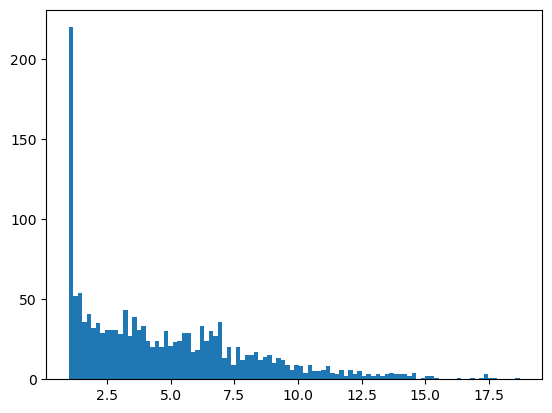

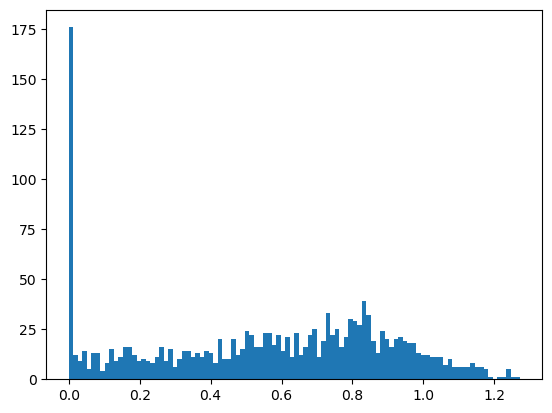

All NTS max neurons : 1075


/var/folders/14/3j7hb71x7tzdv5b7_7_kv4nc0000gn/T/ipykernel_94560/3390062459.py:201: RuntimeWarning: divide by zero encountered in divide
  B1_max_divide = np.divide(combine_B1_extract[:,pool_end_index],B1_max)


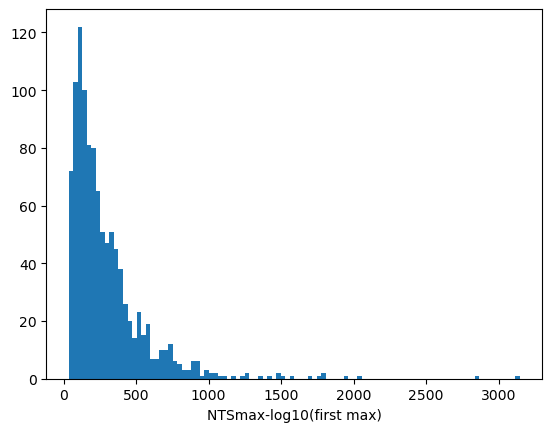

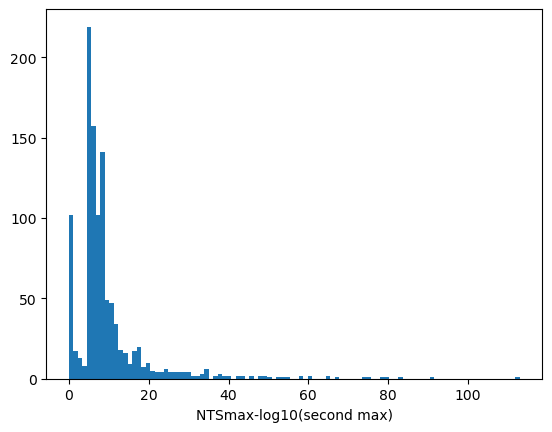

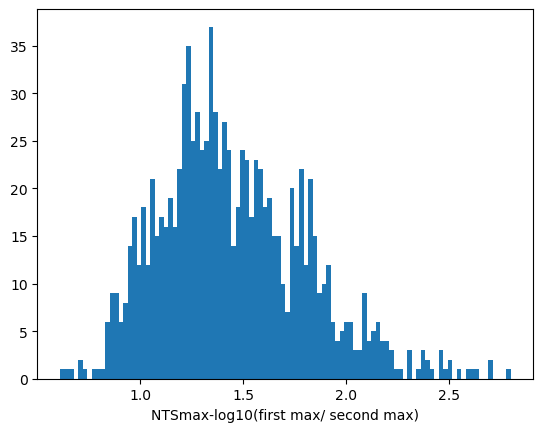

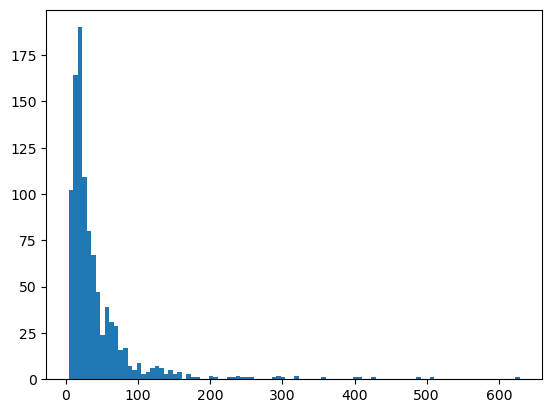

All NTS max neurons after 10 fold injection-projection filter: 990
All NTS max neurons with barcodes in selected target: 920
16
['Injection', 'NAc', 'VMPO', 'BNST', 'PVH', 'PVT', 'LH', 'CeA', 'DMH', 'Arc', 'ZI', 'PAG', 'DR', 'LPB', 'LC', 'VLM', 'Cord']


In [2]:
data1= [] 
data1 = copy.deepcopy(B1)

data1norm = copy.deepcopy(B1norm)

import pandas as pd
csv_fname = pjoin(data_dir, 'MAPSeq_RegionCode.csv')
region_code = pd.read_csv(csv_fname)
region_code_name = region_code.Name

#print(region_code)

## Extract each brain's results from the data frame
B1_original_index = region_code['B1']-1
B1_extract = data1[:,B1_original_index]
B1norm_extract = data1norm[:,B1_original_index]

end = np.size(B1norm_extract,1) #the end index of the lenth
print('Total B1 neurons:',np.size(B1_extract,0))


#### Filter Neurons with negative controls #########
B1_original_length = np.size(B1norm_extract,0)

region_to_filter = ['Cord 3', 'Cord 4','V1','Negative','WT RNA control','L1 target','Water target','water injection']
for rr in region_to_filter: 
    B1_barcode_index=[]
    B1_filter_index=[]
    B1_filter_index = region_code.loc[region_code_name==rr].index
    B1_barcode_index = np.where(B1_extract[:,B1_filter_index] == 0)[0]
    if np.size(B1_barcode_index)>0:
        B1_extract= np.squeeze(B1_extract[B1_barcode_index,:])
        B1norm_extract = np.squeeze(B1norm_extract[B1_barcode_index,:])
B1_extract= np.squeeze(B1_extract)
B1norm_extract = np.squeeze(B1norm_extract)
B1_filter_length = np.size(B1norm_extract,0)
print('Total B1 neurons after filter:',np.size(B1_extract,0))
########   END  ########### Filter Neurons with negative controls #########

###### Combine Cord ############
region_to_combine = ['Cord 1', 'Cord 2','Cord 5']
B1_combine_index = []
for rr in region_to_combine:
    B1_combine_index.append(region_code.loc[region_code['Name']==rr].index)

spinal_cord_all = np.sum(B1_extract[:,B1_combine_index],axis=1)
B1_extract = np.append(B1_extract,spinal_cord_all,axis = 1)

norm_spinal_cord_all = np.sum(B1norm_extract[:,B1_combine_index],axis=1)
B1norm_extract = np.append(B1norm_extract,norm_spinal_cord_all,axis = 1)
region_code_name = np.append(region_code_name,'Cord')
########   END  ########### Combine Cord ############

B1norm_max_id_all = np.transpose([np.argmax(B1norm_extract,axis =1)])

NTS_left_index =  int(region_code[region_code['Name']=='NTS-L'].B1_index)
B1norm_keep_left= np.where(B1norm_max_id_all == NTS_left_index)[0]
B1norm_filter_left= np.where(B1norm_max_id_all != NTS_left_index)[0]
B1_extract_filter_left= np.squeeze(B1_extract[B1norm_filter_left,:])
B1_extract_left = np.squeeze(B1_extract[B1norm_keep_left,:])
B1norm_extract_filter_left = np.squeeze(B1norm_extract[B1norm_filter_left,:])
B1norm_extract_left = np.squeeze(B1norm_extract[B1norm_keep_left,:])

print('B1 left NTS max neurons:',np.size(B1norm_extract_left,0))

NTS_right_index =  int(region_code[region_code['Name']=='NTS-R'].B1_index)
B1norm_keep_right = np.where(B1norm_max_id_all == NTS_right_index)[0]
B1norm_filter_right = np.where(B1norm_max_id_all != NTS_right_index)[0]
B1_extract_filter_right= np.squeeze(B1_extract[B1norm_filter_right,:])
B1_extract_right= np.squeeze(B1_extract[B1norm_keep_right,:])
B1norm_extract_filter_right = np.squeeze(B1norm_extract[B1norm_filter_right,:])
B1norm_extract_right = np.squeeze(B1norm_extract[B1norm_keep_right,:])
print('B1 right NTS max neurons:',np.size(B1norm_extract_right,0))


B1norm_filter_both = np.where((B1norm_max_id_all != NTS_left_index)&(B1norm_max_id_all != NTS_right_index))[0]
B1_extract_filter_both= np.squeeze(B1_extract[B1norm_filter_both,:])
B1norm_extract_filter_both = np.squeeze(B1norm_extract[B1norm_filter_both,:])
B1norm_max_both = np.transpose([np.amax(B1norm_extract_filter_both[:,1:],axis =1)])
print('B1 non-NTS max neurons:',np.size(B1norm_max_both,0))

###
B1_extract_filter_both_sort = np.sort(B1_extract_filter_both, axis=1)
B1_extract_filter_both_max_divide= np.divide(B1_extract_filter_both_sort[:,-1],B1_extract_filter_both_sort [:,-2])
import matplotlib.pyplot as plt
import numpy as np
plt.hist(B1_extract_filter_both_max_divide[np.isfinite(B1_extract_filter_both_max_divide)],bins=100)
plt.show()
plt.hist(np.log10(B1_extract_filter_both_max_divide[np.isfinite(B1_extract_filter_both_max_divide)]),bins=100)
plt.show()


####### Rename based on grouped projections ###########
    ### Read new order
csv_fname = pjoin(data_dir, '2508_MAPSeq_RegionCode_Pooled_Select_New.csv')
region_code_pool = pd.read_csv(csv_fname)
region_code_name_pool = region_code_pool.Pool_Name
region_code_index_pool = region_code_pool.Pool_Index

ci=0
NTS_left_region_code = []
while ci <= len(region_code_name)-1:
    rname = region_code_name[ci]
    if rname == 'NTS-L':
        rname = 'NTS-Injection'
        NTS_left_region_code.append(rname)
    else:
        if '-L' in rname:
            rname = rname.replace('-L', '-Ipsi')
        elif '-R' in rname:
            rname = rname.replace('-R', '-Contra')
        else:
            rname = rname
        NTS_left_region_code.append(rname)
    ci = ci + 1
#Sort to the final order
A = np.array(NTS_left_region_code)
B = np.array(region_code_name_pool)
sort_order_left = np.nonzero(B[:,None] == A)[1]
B1norm_extract_left = B1norm_extract_left[:,sort_order_left]
B1_extract_left = B1_extract_left[:,sort_order_left]

ci=0
NTS_right_region_code = []
while ci <= len(region_code_name)-1:
    rname = region_code_name[ci]
    if rname == 'NTS-R':
        rname = 'NTS-Injection'
        NTS_right_region_code.append(rname)
    else:
        if '-R' in rname:
            rname = rname.replace('-R', '-Ipsi')
        elif '-L' in rname:
            rname = rname.replace('-L', '-Contra')
        else:
            rname = rname
        NTS_right_region_code.append(rname)
    ci = ci + 1
#Sort to the final order
A = np.array(NTS_right_region_code)
B = np.array(region_code_name_pool)
sort_order_right = np.nonzero(B[:,None] == A)[1]
B1norm_extract_right = B1norm_extract_right[:,sort_order_right]
B1_extract_right = B1_extract_right[:,sort_order_right]

####   END   ###### Rename based on grouped projections ###########




#######

# ######Original
# #projection strength: normalize by spike-in RNA and the maximal projections of that neuron
# B1_ps = np.divide(B1norm_extract[:,1:],B1norm_max)
# B2_ps = np.divide(B2norm_extract[:,1:],B2norm_max)

# barcode_count1 = np.sum(B1_extract != -1, axis=0)-np.sum(B1_extract == 0, axis=0)
# barcode_count2 = np.sum(B2_extract != -1, axis=0)-np.sum(B2_extract== 0, axis=0)
# barcode_percent1 = barcode_count1/barcode_count1[0]
# barcode_percent2 = barcode_count2/barcode_count2[0]
# average_barcode_percent = (barcode_percent1+barcode_percent2)/2
# #average_barcode_percent = barcode_percent2
# barcode_region_count1= np.sum(B1_extract[:,1:] != -1, axis=1)-np.sum(B1_extract[:,1:]== 0, axis=1)
# barcode_region_count2= np.sum(B2_extract[:,1:] != -1, axis=1)-np.sum(B2_extract[:,1:]== 0, axis=1)

### exclude PFC and V1
#projection strength: normalize by spike-in RNA and the maximal projections of that neuron
# B1_ps = np.divide(B1norm_extract[:,1:end-1],B1norm_max)
# B2_ps = np.divide(B2norm_extract[:,1:end-1],B2norm_max)

#####Filter NTS neurons with a threshold##########

# B1_barcode_index_injection_left = np.where(B1_extract[:,39] >= 0)[0]
# B1_barcode_index_injection_right = np.where(B1_extract[:,40] >= 0)[0]

# B1_extract= np.squeeze(B1_extract[B1_barcode_index_injection_left,:])
# B1norm_extract = np.squeeze(B1norm_extract[B1_barcode_index_injection_left,:])


# #### Target
# B1_max = np.transpose([np.amax(B1_extract[:,1:],axis =1)])

# B1_barcode_index_target = np.where(B1_max >= 5)[0]
# B1_extract= np.squeeze(B1_extract[B1_barcode_index_target,:])
# B1norm_extract = np.squeeze(B1norm_extract[B1_barcode_index_target,:])
#print('B1 filtered NTS max neurons:',np.size(B1_extract,0))

######   End   #################Filter NTS neurons with a threshold##########

### Filter neurons that do not have barcodes in any selected regions ####


combine_B1_extract = np.vstack((B1_extract_left, B1_extract_right))
combine_B1norm_extract = np.vstack((B1norm_extract_left, B1norm_extract_right))
pool_end_index = len(region_code_name_pool)-1
print('All NTS max neurons :',np.size(combine_B1_extract,0))
#### Filter neurons that are 10 folds higher ##############

B1_max =np.amax(combine_B1_extract[:,0:pool_end_index],axis =1)
B1_max_divide = np.divide(combine_B1_extract[:,pool_end_index],B1_max)
import matplotlib.pyplot as plt
import numpy as np
plt.hist(combine_B1_extract[:,pool_end_index],bins = 100)
plt.xlabel('NTSmax-log10(first max)')
plt.show()
plt.hist(B1_max,bins = 100)
plt.xlabel('NTSmax-log10(second max)')
plt.show()
plt.hist(np.log10(B1_max_divide[np.isfinite(B1_max_divide)]),bins=100)
plt.xlabel('NTSmax-log10(first max/ second max)')
plt.show()
plt.hist(B1_max_divide[np.isfinite(B1_max_divide)],bins=100)
plt.show()

B1_barcode_index_selected = np.where(B1_max_divide>=10)[0]
if np.size(B1_barcode_index_selected)>0:
    combine_B1_extract= np.squeeze(combine_B1_extract[B1_barcode_index_selected,:])
    combine_B1norm_extract = np.squeeze(combine_B1norm_extract[B1_barcode_index_selected,:])
print('All NTS max neurons after 10 fold injection-projection filter:',np.size(combine_B1_extract,0))


pool_end_index = len(region_code_name_pool)-1
B1norm_max = np.transpose([np.amax(combine_B1norm_extract[:,0:pool_end_index],axis =1)])
B1_barcode_index_selected = np.where(B1norm_max!=0)[0]


if np.size(B1_barcode_index_selected)>0:
    combine_B1_extract= np.squeeze(combine_B1_extract[B1_barcode_index_selected,:])
    combine_B1norm_extract = np.squeeze(combine_B1norm_extract[B1_barcode_index_selected,:])

print('All NTS max neurons with barcodes in selected target:',np.size(combine_B1_extract,0))



#########     NTS Left Neuron- Preprocessing     ################ 
LR_combine_name = ['Injection']
LR_combine_B1_extract = combine_B1_extract[:,-1]
LR_combine_B1norm_extract = combine_B1norm_extract[:,-1]

#print(region_code['Name'])
ci=0
while ci <= len(region_code_name_pool)-2:
    rname = region_code_name_pool[ci]
    if '-Ipsi' in rname:
        L_name = rname
        R_name = rname.replace('-Ipsi', '-Contra')
        cname = rname.replace('-Ipsi', '')
        LR_combine_B1= np.sum([combine_B1_extract[:,ci],combine_B1_extract[:,ci+1]],axis=0)
        LR_combine_B1norm= np.sum([combine_B1norm_extract[:,ci],combine_B1norm_extract[:,ci+1]],axis=0)
        LR_combine_name.append(cname)
        LR_combine_B1_extract = np.vstack((LR_combine_B1_extract, LR_combine_B1))
        LR_combine_B1norm_extract = np.vstack((LR_combine_B1norm_extract, LR_combine_B1norm))
        ci += 2

    elif '-Contra' in rname:
        if rname !='NTS-Contra':
            R_name = rname
            L_name = rname.replace('-Contra', '-Ipsi')
            cname = rname.replace('-Ipsi', '')
            LR_combine_B1= np.sum([combine_B1_extract[:,ci],combine_B1_extract[:,ci+1]],axis=0)
            LR_combine_B1norm= np.sum([combine_B1norm_extract[:,ci],combine_B1norm_extract[:,ci+1]],axis=0)
            LR_combine_name.append(cname)
            LR_combine_B1_extract = np.vstack((LR_combine_B1_extract, LR_combine_B1))
            LR_combine_B1norm_extract = np.vstack((LR_combine_B1norm_extract, LR_combine_B1norm))
            ci += 2
        else:
            cname = rname
            LR_combine_name.append(cname)
            LR_combine_B1= combine_B1_extract[:,ci]
            LR_combine_B1norm= combine_B1norm_extract[:,ci]
            LR_combine_B1_extract = np.vstack((LR_combine_B1_extract, LR_combine_B1))
            LR_combine_B1norm_extract = np.vstack((LR_combine_B1norm_extract, LR_combine_B1norm))
            ci += 1

    else:
        cname = rname
        LR_combine_name.append(cname)
        LR_combine_B1= combine_B1_extract[:,ci]
        LR_combine_B1norm= combine_B1norm_extract[:,ci]
        LR_combine_B1_extract = np.vstack((LR_combine_B1_extract, LR_combine_B1))
        LR_combine_B1norm_extract = np.vstack((LR_combine_B1norm_extract, LR_combine_B1norm))
        ci += 1     


pool_end_index = len(LR_combine_name)-1
print(pool_end_index)

combine_B1_extract = np.transpose(LR_combine_B1_extract)
combine_B1norm_extract = np.transpose(LR_combine_B1norm_extract)


B1norm_max = np.transpose([np.amax(combine_B1norm_extract[:,1:pool_end_index+1],axis =1)])
B1_ps= np.divide(combine_B1norm_extract[:,1:pool_end_index+1],B1norm_max)

barcode_count1 = np.sum(combine_B1_extract != -1, axis=0)-np.sum(combine_B1_extract== 0, axis=0)
barcode_percent1= barcode_count1/barcode_count1[0]
barcode_region_count1= np.sum(combine_B1_extract[:,1:pool_end_index+1] != -1, axis=1)-np.sum(combine_B1_extract[:,1:pool_end_index+1]== 0, axis=1)

region_code_name_pool=LR_combine_name
print(region_code_name_pool)

## 1.1 Heatmap_NTSmax_left right combined

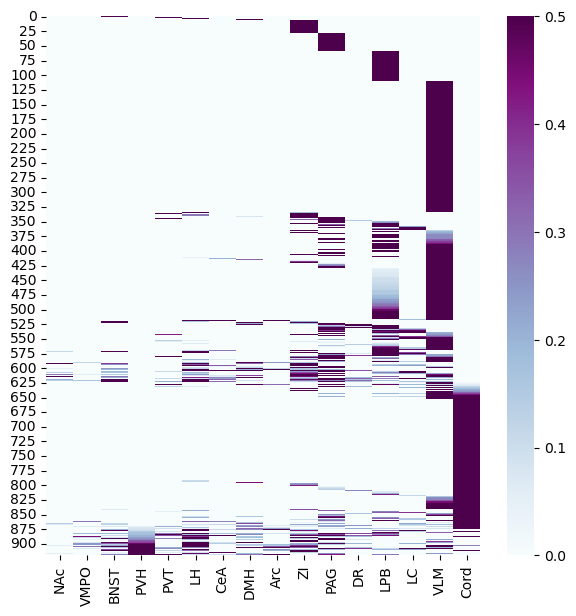

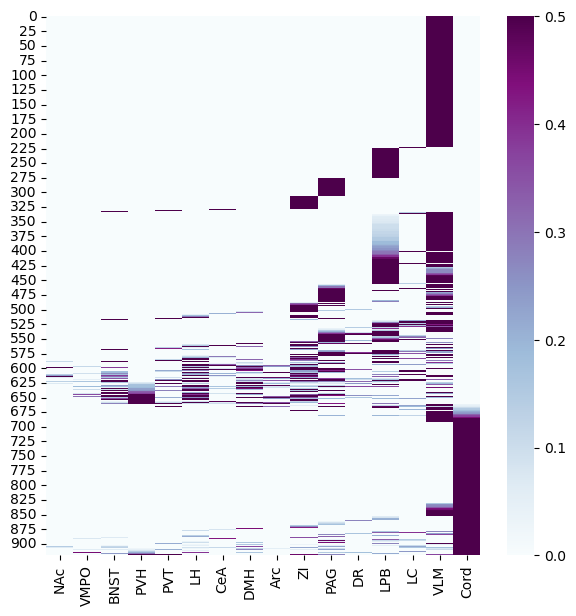

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.plot(barcode_count1)
#plt.plot(barcode_count2)

#pulls first
#B1_norm_pool = np.vstack((B1_ps_left,B1_ps_right))
barcode_region_count12 = barcode_region_count1
B1B2norm_pool  = B1_ps[:,0:pool_end_index]

#barcode_region_count12=barcode_region_count2

fig, ax = plt.subplots(figsize=(7, 7))

keys12 = np.vstack([[B1B2norm_pool[:,i] for i in range(0,pool_end_index,1)],barcode_region_count12 ,B1B2norm_pool[:,15],B1B2norm_pool[:,3]])
# sort from column to column except the first column(NTS) (if include should be (start,-1,-1))
#B1B2norm_pool_VLM_sort = B1B2norm_pool[np.lexsort((keys12))[::-1]]#[::-1] for descending
B1B2norm_pool_VLM_sort = B1B2norm_pool [np.lexsort((keys12))]
x_axis_labels=region_code_name_pool[1:pool_end_index+1]

sns.heatmap(B1B2norm_pool_VLM_sort ,vmin=0, vmax=0.5,cmap="BuPu",xticklabels=x_axis_labels)
plt.show()
fig, ax = plt.subplots(figsize=(7,7))
keys12_PVH = np.vstack([[B1B2norm_pool[:,i] for i in range(pool_end_index-1,-1,-1)],barcode_region_count12,B1B2norm_pool[:,3],B1B2norm_pool[:,15]])
# sort from column to column except the first column(NTS) (if include should be (start,-1,-1))
#B1B2norm_pool_PVH_sort = B1B2norm_pool[np.lexsort((keys12_PVH))[::-1]]#[::-1] for descending
B1B2norm_pool_PVH_sort = B1B2norm_pool[np.lexsort((keys12_PVH))]
x_axis_labels=region_code_name_pool[1:pool_end_index+1]
sns.heatmap(B1B2norm_pool_PVH_sort ,vmin=0, vmax=0.5,cmap="BuPu",xticklabels=x_axis_labels)
plt.show()


## 1.2 Clusterheatmap

/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


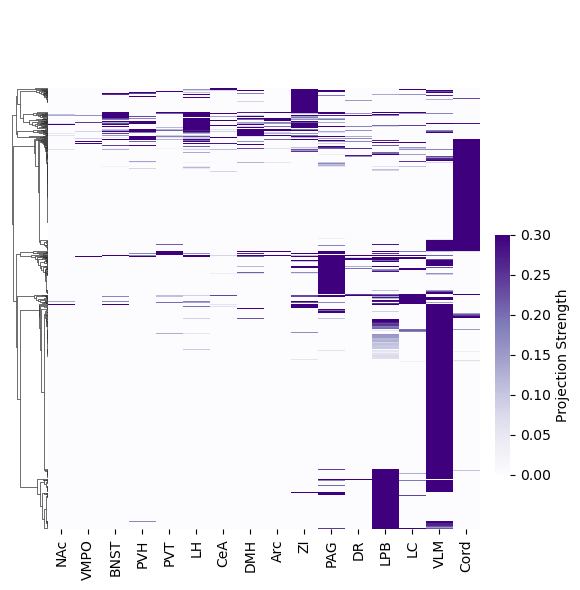

In [4]:
###Cluster map
import sys
sys.setrecursionlimit(100000)

import numpy as np
from scipy.io import savemat

# Create a sample matrix
matrix = B1B2norm_pool
# Save the matrix to a .mat file
savemat('ProjectionStrength.mat', {'ProjectionStrength_neuronxregion': matrix,'RegionName': region_code_name_pool[1:pool_end_index+1]})


x_axis_labels=region_code_name_pool[1:pool_end_index+1]
y_axis_labels = range(np.size(B1B2norm_pool,0)-1)
ch = sns.clustermap(B1B2norm_pool ,metric="correlation",vmin=0, vmax=0.3,
                    cmap="Purples", col_cluster=False,
               xticklabels=x_axis_labels,figsize = (5,6),
               dendrogram_ratio=(.08, .15),
               cbar_pos=(1, .2, .03, .4),cbar_kws={'label': 'Projection Strength'},
               yticklabels=False )
plt.show()

ch.savefig('Figure2B_APDorder.svg')

# Get the reordered data
row_order = ch.dendrogram_row.reordered_ind
reordered_data = B1B2norm_pool[row_order, :]
# Save to CSV
rd = pd.DataFrame(reordered_data, columns=x_axis_labels)

# Save to Excel
rd.to_excel("Figure2B_reordered_matrix.xlsx", index_label="Row")


## 1.4 P(A|B)

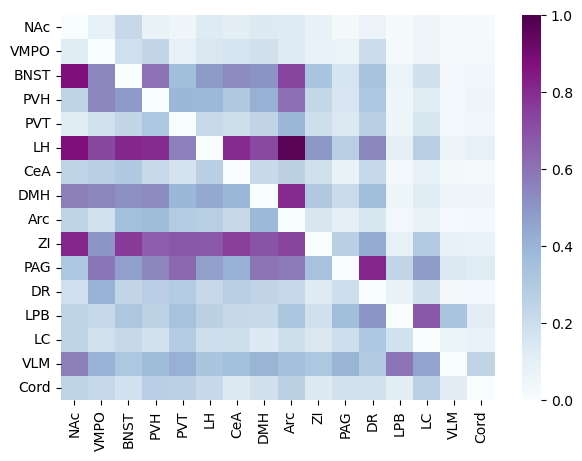

In [5]:
# P(A|B)
B1B2_pool = combine_B1_extract
end = pool_end_index
#B1B2_pool = B2_extract
p = np.zeros([end,end])
for BB in range(1,end+1,1):
  for AA in range(1,end+1,1):
    if AA == BB:
      continue
    countB =np.sum(B1B2_pool[:,BB] != 0, axis=0)
    mask = np.logical_and(B1B2_pool[:,AA] != 0 , B1B2_pool[:,BB] != 0)
    #print(mask)
    countBA = np.sum(mask == True ,axis = 0)
    #print(countBA)
    p[AA-1,BB-1] = countBA/countB

#print(np.sum(B1B2_pool[:,AA] != 0, axis=0))
fig, ax = plt.subplots(figsize=(7, 5))

#keys12 = np.vstack([[B1B2norm_pool[:,i] for i in range(1,end-2,1)],barcode_region_count12])
# sort from column to column except the first column(NTS) (if include should be (start,-1,-1))
#B1B2norm_pool_VLM_sort = B1B2norm_pool[np.lexsort((keys12))[::-1]]#[::-1] for descending

y_axis_labels = region_code_name_pool[1:end+1]
x_axis_labels = region_code_name_pool[1:end+1]
sns.heatmap(p,vmin=0, vmax=1,cmap="BuPu",xticklabels=x_axis_labels,yticklabels = y_axis_labels)
plt.show()
fig.savefig('FigureS2A_P(AB).svg')


# Save to CSV
pab = pd.DataFrame(p,columns=x_axis_labels, index=x_axis_labels)

# Save to Excel
pab.to_excel("FigureS2A_P(AB)_matrix.xlsx", index_label="Row")


## 1.4.1 JSD Cluster map

/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


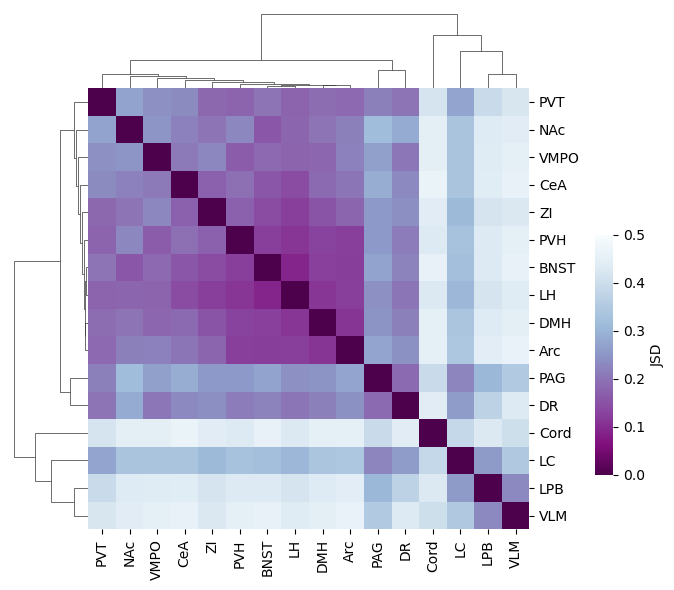

In [6]:
from __future__ import print_function
import time

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

from scipy.spatial.distance import cdist

correlations = cdist(combine_B1_extract[:,1:end+1].T, combine_B1_extract[:,1:end+1].T, metric='correlation')

B1B2_pool = combine_B1_extract
end = pool_end_index
#B1B2_pool = B2_extract

p = np.zeros([end,end])
for BB in range(1,end+1,1):
  for AA in range(1,end+1,1):
    countB =np.sum(B1B2_pool[:,BB] != 0, axis=0)
    mask = np.logical_and(B1B2_pool[:,AA] != 0 , B1B2_pool[:,BB] != 0)
    #print(mask)
    countBA = np.sum(mask == True ,axis = 0)
    #print(countBA)
    p[AA-1,BB-1] = (1 +countBA)/(end + countB)
    #p[AA-1,BB-1] = (countBA)/(countB)


JSD = np.zeros([end,end])
from scipy.spatial import distance
for BB in range(1,end+1,1):
  for AA in range(1,end+1,1):
    JSD[AA-1,BB-1] = distance.jensenshannon(p[:,AA-1],p[:,BB-1])

#print(np.sum(B1B2_pool[:,AA] != 0, axis=0))
#correlations = cdist(p.T, p, metric='correlation')
###Cluster map
import sys
sys.setrecursionlimit(100000)


x_axis_labels=region_code_name_pool[1:pool_end_index+1]
ch = sns.clustermap(JSD ,metric="correlation",vmin=0,vmax=0.5,
                    cmap="BuPu_r", 
               xticklabels=x_axis_labels,figsize = (6,6),
               dendrogram_ratio=(.15, .15),
               cbar_pos=(1, .2, .03, .4),cbar_kws={'label': 'JSD'},
               yticklabels=x_axis_labels)
plt.show()
ch.savefig('Figure2D_JSDclustermap.svg')
cluster_labels = [t.get_text() for t in ch.ax_heatmap.yaxis.get_majorticklabels()]

In [7]:
import numpy as np

# 1) Orders used in the figure
row_order = ch.dendrogram_row.reordered_ind
col_order = ch.dendrogram_col.reordered_ind

# 2) Reordered labels (to match the displayed clustermap)
row_labels_ordered = [x_axis_labels[i] for i in row_order]
col_labels_ordered = [x_axis_labels[i] for i in col_order]

# 3) Reordered JSD matrix (exactly what the heatmap shows)
JSD_reordered = JSD[np.ix_(row_order, col_order)]


# -------- Save as CSV (journal-friendly) --------
# Raw JSD with labels in both header and first column
with open('JSD_raw.csv', 'w') as f:
    f.write(',' + ','.join(x_axis_labels) + '\n')
    for idx, row in enumerate(JSD):
        f.write(f'{x_axis_labels[idx]},' + ','.join(map(str, row)) + '\n')

# Reordered JSD (matches figure exactly)
with open('JSD_reordered.csv', 'w') as f:
    f.write(',' + ','.join(col_labels_ordered) + '\n')
    for i, row in enumerate(JSD_reordered):
        f.write(f'{row_labels_ordered[i]},' + ','.join(map(str, row)) + '\n')

# Row/col order mapping tables (position → original index → label)
with open('row_order_mapping.csv', 'w') as f:
    f.write('position,original_index,label\n')
    for pos, idx in enumerate(row_order):
        f.write(f'{pos},{idx},{x_axis_labels[idx]}\n')

with open('col_order_mapping.csv', 'w') as f:
    f.write('position,original_index,label\n')
    for pos, idx in enumerate(col_order):
        f.write(f'{pos},{idx},{x_axis_labels[idx]}\n')

## 1.5 Multifurcating

[0.51304348 0.27717391 0.07608696 0.04021739 0.02065217 0.07282609]


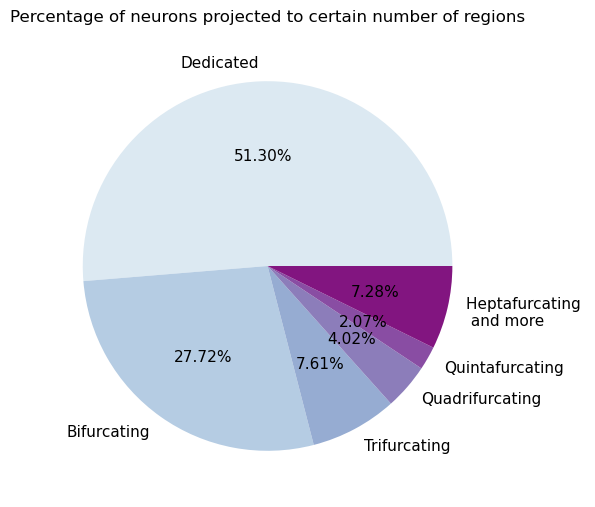

255
920


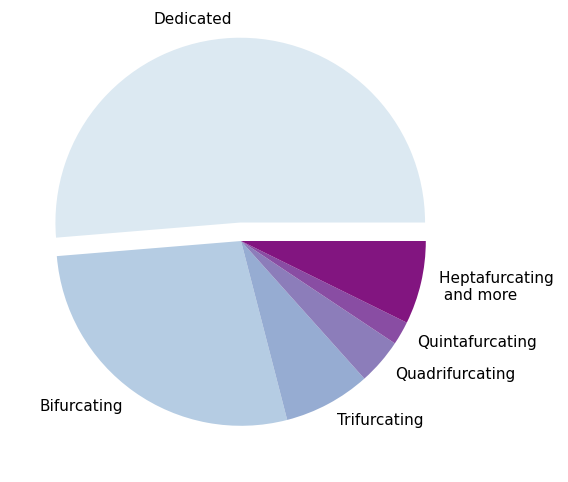

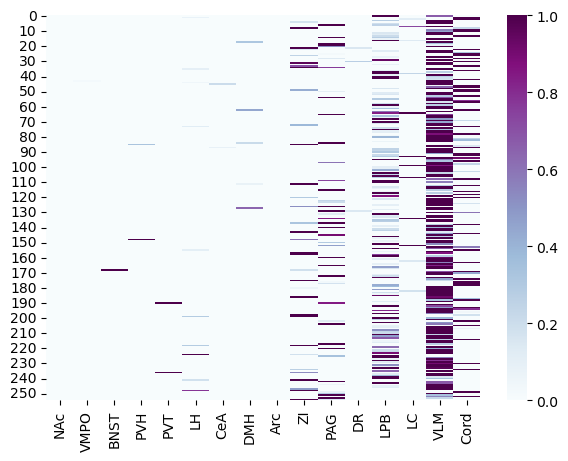

In [8]:
c1 = np.sum(barcode_region_count1 == 1 )/np.size(barcode_region_count1)
c2 = np.sum(barcode_region_count1 == 2 )/np.size(barcode_region_count1)
c3 = np.sum(barcode_region_count1 == 3 )/np.size(barcode_region_count1)
c4 = np.sum(barcode_region_count1 == 4 )/np.size(barcode_region_count1)
c5 = np.sum(barcode_region_count1 == 5 )/np.size(barcode_region_count1)
c6 = np.sum(barcode_region_count1 >=6 )/np.size(barcode_region_count1)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#original pie chart
fig, ax = plt.subplots(figsize =(6,6))
furcating = np.array([c1,c2,c3,c4,c5,c6,])
print(furcating)
furcating_labels = ['Dedicated', 'Bifurcating','Trifurcating','Quadrifurcating','Quintafurcating','Heptafurcating \n and more']
furcating_explode = [0,0,0,0,0,0]
plt.pie(furcating, 
        labels = furcating_labels, 
        explode = furcating_explode,
        autopct = '%.2f%%',
        textprops = {'fontsize':11},
        colors = sns.color_palette('BuPu'))

plt.title(
    label = 'Percentage of neurons projected to certain number of regions',
    fontdict = {'fontsize':12},
    pad=10)
plt.show()

fig2, ax = plt.subplots(figsize =(6,6))
furcating = np.array([c1,c2,c3,c4,c5,c6,])
furcating_labels = ['Dedicated', 'Bifurcating','Trifurcating','Quadrifurcating','Quintafurcating','Heptafurcating \n and more']
furcating_explode = [0.1,0,0,0,0,0]
plt.pie(furcating, 
        labels = furcating_labels, 
        explode = furcating_explode,
        textprops = {'fontsize':11},
        colors = sns.color_palette('BuPu'))
fig2.savefig('Figure2C.svg')

fig, ax = plt.subplots(figsize=(7, 5))
y_axis_labels = region_code_name_pool[1:end+1]
x_axis_labels = region_code_name_pool[1:end+1]
index_2 = list(np.where(barcode_region_count1 == 2))
print(np.size(index_2,1))
print(np.size(barcode_region_count1))
sns.heatmap(np.squeeze(B1B2norm_pool[index_2,:]),cmap="BuPu",xticklabels=x_axis_labels)
plt.show()

### 1.5.0-2 Stacked bar plot

PVT
NAc
VMPO
CeA
ZI
PVH
BNST
LH
DMH
Arc
PAG
DR
Cord
LC
LPB
VLM


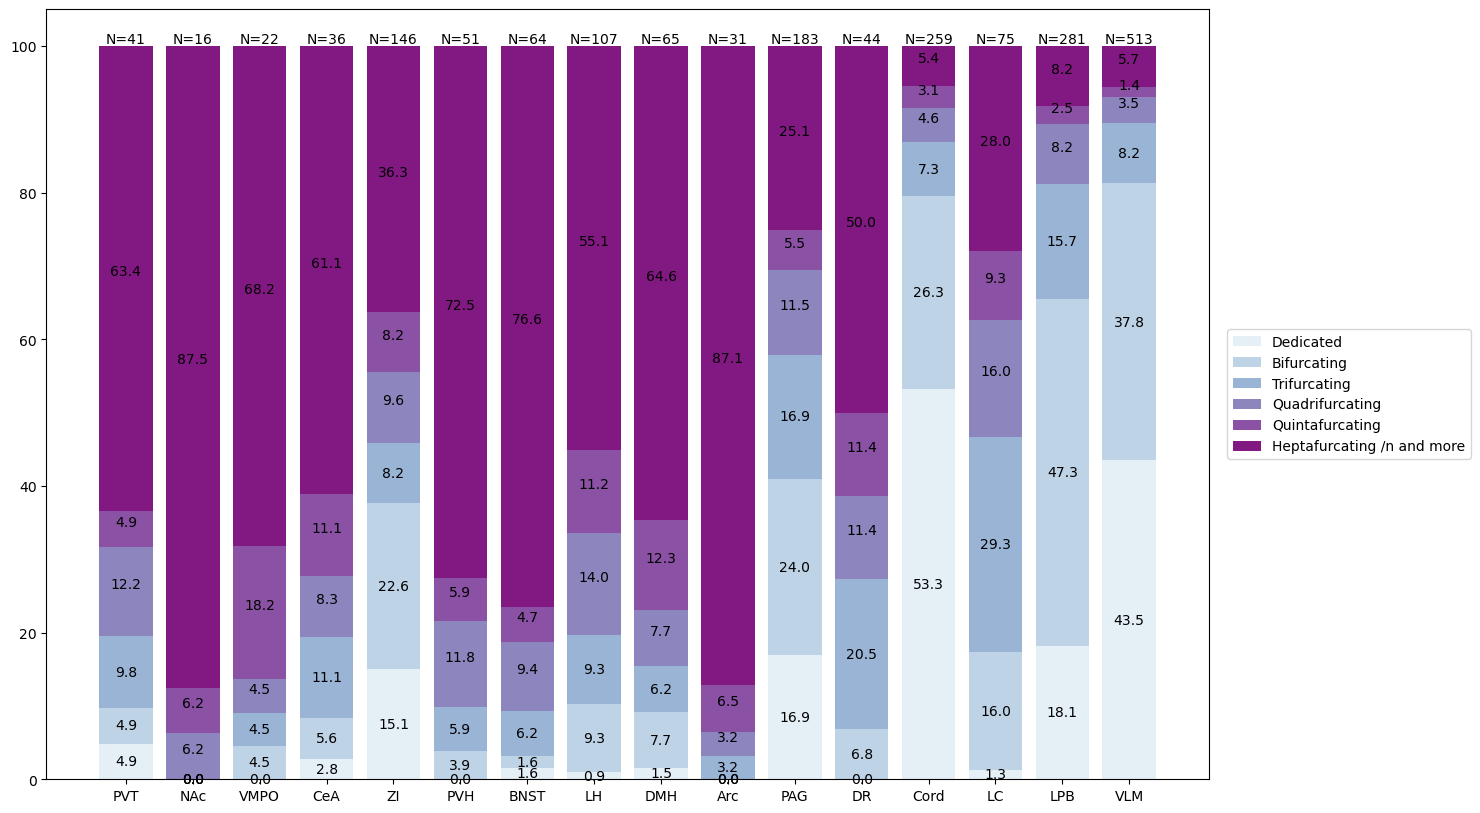

In [9]:
import math
import pandas as pd
B1B2_pool = combine_B1_extract.copy()

from scipy.optimize import fsolve
end = pool_end_index
#motif_candidate = region_code_name_pool[1:end+1]

motif_candidate = cluster_labels ### see clusterheatmap
ss=-1
mm = 0
y1= np.array([])
y2= np.array([])
y3= np.array([])
y4= np.array([])
y5= np.array([])
y6= np.array([])
yy1= np.array([])
yy2= np.array([])
yy3= np.array([])
yy4= np.array([])
yy5= np.array([])
yy6= np.array([])
snum = np.array([])
for m in motif_candidate:
    print(m)
    ss=ss+1
    A = np.array(region_code_name_pool)
    B = np.array([m])
    motif_index = np.nonzero(B[:,None] == A)[1]
    mask0 = np.logical_and(B1B2_pool[:,motif_index[0]]!=0, B1B2_pool[:,motif_index[0]] != 0)

    for AA in motif_index:
        mask0 = np.logical_or(mask0, B1B2_pool[:,AA] != 0)

    obs_6 = np.sum(mask0 == True ,axis = 0)
    sp_index = np.where(mask0 == True)
    B1_motif_extract= np.squeeze(combine_B1_extract[sp_index,:])

    #print(NameFilter[ss],' projecting neurons:',obs_6 )

    barcode_region_count1_each= np.sum(B1_motif_extract[:,1:pool_end_index+1] != -1, axis=1)-np.sum(B1_motif_extract[:,1:pool_end_index+1]== 0, axis=1)
    
    c1 = np.sum(barcode_region_count1_each == 1 )/np.size(barcode_region_count1_each)*100
    c2 = np.sum(barcode_region_count1_each == 2 )/np.size(barcode_region_count1_each)*100
    c3 = np.sum(barcode_region_count1_each == 3 )/np.size(barcode_region_count1_each)*100
    c4 = np.sum(barcode_region_count1_each == 4 )/np.size(barcode_region_count1_each)*100
    c5 = np.sum(barcode_region_count1_each == 5 )/np.size(barcode_region_count1_each)*100
    c6 = np.sum(barcode_region_count1_each >= 6 )/np.size(barcode_region_count1_each)*100
  
    y1=np.append(y1,c1)
    y2=np.append(y2,c2)
    y3=np.append(y3,c3)
    y4=np.append(y4,c4)
    y5=np.append(y5,c5)
    y6=np.append(y6,c6)
    snum=np.append(snum,np.size(barcode_region_count1_each))

    cc1 = np.sum(barcode_region_count1_each == 1 )
    cc2 = np.sum(barcode_region_count1_each == 2 )
    cc3 = np.sum(barcode_region_count1_each == 3 )
    cc4 = np.sum(barcode_region_count1_each == 4 )
    cc5 = np.sum(barcode_region_count1_each == 5)
    cc6 = np.sum(barcode_region_count1_each >= 6 )
    yy1=np.append(yy1,cc1)
    yy2=np.append(yy2,cc2)
    yy3=np.append(yy3,cc3)
    yy4=np.append(yy4,cc4)
    yy5=np.append(yy5,cc5)
    yy6=np.append(yy6,cc6)


# Stack bar plot
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

plt.figure(figsize=(15,10))
colors = plt.cm.BuPu(np.linspace(0.1, 0.85, 6))
    
x = motif_candidate 
# stack bars

plt.bar(x, y1, label='Dedicated',color=colors[0])
plt.bar(x, y2 ,bottom=y1,label='Bifurcating',color=colors[1])
plt.bar(x, y3 ,bottom=y1+y2,label='Trifurcating',color=colors[2])
plt.bar(x, y4 ,bottom=y1+y2+y3,label='Quadrifurcating',color=colors[3])
plt.bar(x, y5 ,bottom=y1+y2+y3+y4,label='Quintafurcating',color=colors[4])
plt.bar(x, y6 ,bottom=y1+y2+y3+y4+y5,label='Heptafurcating /n and more',color=colors[5])

for xpos, ypos, yval in zip(x, y1+y2+y3+y4+y5+y6, snum):
    plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")

plt.ylim(0,105)

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.savefig('normalized_stacked_barplot_without_number.svg', bbox_inches='tight', pad_inches=0.03)


# add text annotation corresponding to the percentage of each data.
for xpos, ypos, yval in zip(x, y1/2, y1):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2/2, y2):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2+y3/2, y3):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
for xpos, ypos, yval in zip(x, y1+y2+y3+y4/2, y4):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="bottom")
for xpos, ypos, yval in zip(x, y1+y2+y3+y4+y5/2, y5):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="bottom")
for xpos, ypos, yval in zip(x, y1+y2+y3+y4+y5+y6/2, y6):
    plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="bottom")

plt.ylim(0,105)

plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.savefig('normalized_stacked_barplot_with_number.pdf', bbox_inches='tight', pad_inches=0.03)



In [10]:
import pandas as pd

# Create a DataFrame for % values
stacked_percent_df = pd.DataFrame({
    "Motif": motif_candidate,
    "Dedicated (%)": y1,
    "Bifurcating (%)": y2,
    "Trifurcating (%)": y3,
    "Quadrifurcating (%)": y4,
    "Quintafurcating (%)": y5,
    "Heptafurcating_and_more (%)": y6,
    "Total_N": snum
})

# Create a DataFrame for raw counts
stacked_count_df = pd.DataFrame({
    "Motif": motif_candidate,
    "Dedicated (count)": yy1,
    "Bifurcating (count)": yy2,
    "Trifurcating (count)": yy3,
    "Quadrifurcating (count)": yy4,
    "Quintafurcating (count)": yy5,
    "Heptafurcating_and_more (count)": yy6,
    "Total_N": snum
})

# Save both CSVs
stacked_percent_df.to_csv("FigureS2C_stacked_barplot_source_data_percent.csv", index=False)
stacked_count_df.to_csv("FigureS2C_stacked_barplot_source_data_counts.csv", index=False)

### 1.5.4  t-sne clustering

PC1: 0.72
PC2: 0.09
PC3: 0.05
PC4: 0.03
PC5: 0.02
PC6: 0.02
PC7: 0.01


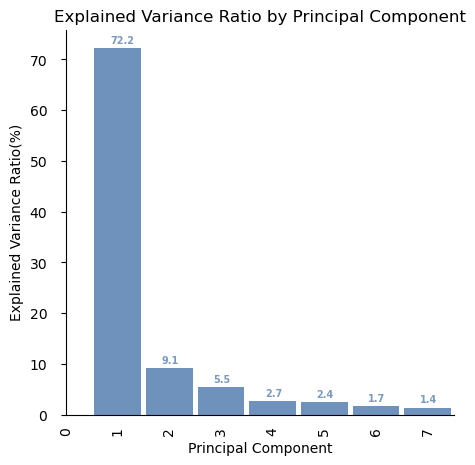

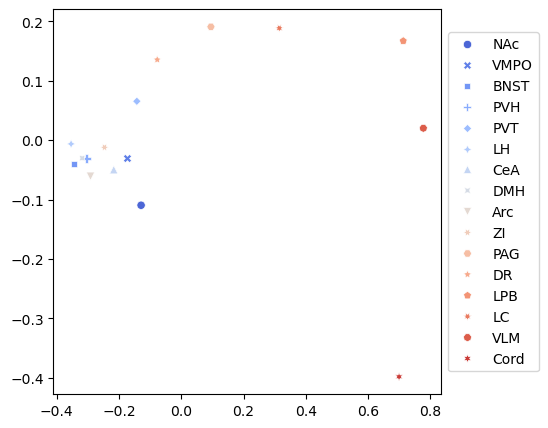

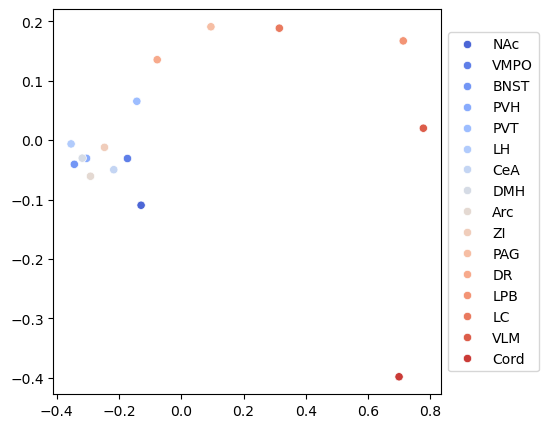

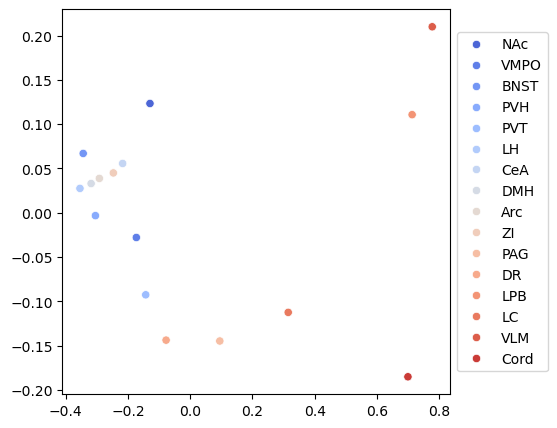

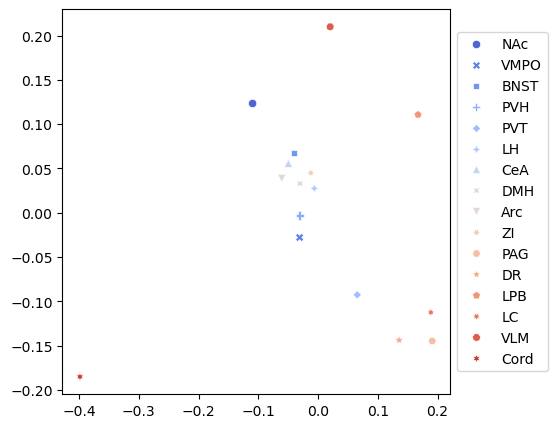

In [11]:
X_train = copy.deepcopy(JSD)
pca = PCA(n_components=7)
X_PCA=pca.fit_transform(X_train)

explained_variance_ratio = pca.explained_variance_ratio_
for indx, evr in enumerate(explained_variance_ratio):
    print(f"PC{indx+1}: {evr:.2f}")
    

import matplotlib.pyplot as plt

target= region_code_name_pool[1:end+1]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
y_lan = le.transform(target)

# set x and y values
x = np.arange(1, len(explained_variance_ratio) + 1)
y = explained_variance_ratio*100
# plot
fig, ax = plt.subplots(figsize =(5,5))
ax.bar(x,y, color = '#6f92bd',width=0.9)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False) # Remove axes splines
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

plt.xlim((0,7.5))
#plt.ylim((0,101))

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_x()+0.3,i.get_height()+1,  
             str(round((i.get_height()), 1)),
             fontsize = 7, fontweight ='bold',
             color = '#7a9ac2')

#Add plot title
# set label and title
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio(%)')
ax.set_title('Explained Variance Ratio by Principal Component')

plt.xticks(rotation=90, ha='center')
plt.show()
fig.savefig('FigureS2B_pca_explaned variance.svg')

fig, ax = plt.subplots(figsize =(5,5))
ax1 =sns.scatterplot(
    x=X_PCA[:,0], y= X_PCA[:,1],
    hue=target,
    style = target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
fig.savefig('pca12_style.pdf')

fig, ax = plt.subplots(figsize =(5,5))
ax1 =sns.scatterplot(
    x=X_PCA[:,0], y= X_PCA[:,1],
    hue=target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
fig.savefig('pca12.pdf')

fig, ax = plt.subplots(figsize =(5,5))
ax1 =sns.scatterplot(
    x=X_PCA[:,0], y= X_PCA[:,2],
    hue=target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
fig.savefig('pca13.pdf')


fig, ax = plt.subplots(figsize =(5,5))
ax1 =sns.scatterplot(
    x=X_PCA[:,1], y= X_PCA[:,2],
    hue=target,
    style = target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
fig.savefig('pca23.pdf')

/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


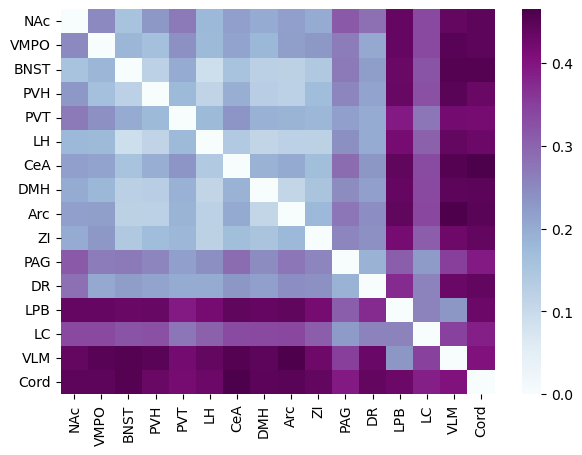

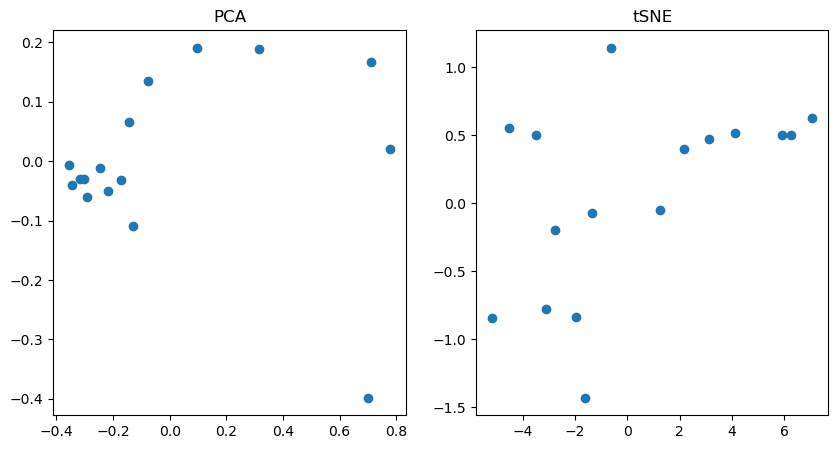

<Figure size 1000x1600 with 0 Axes>

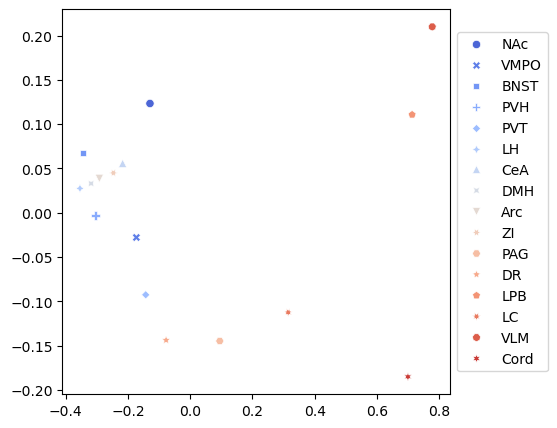

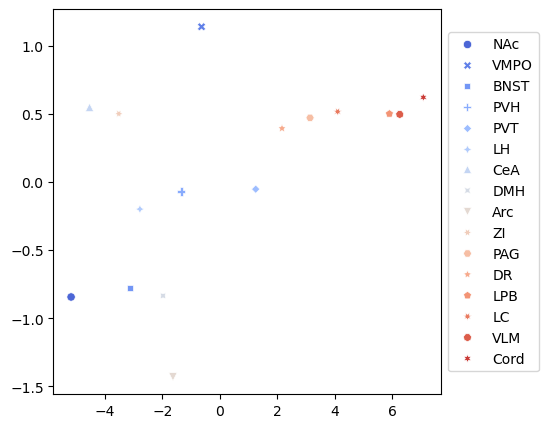

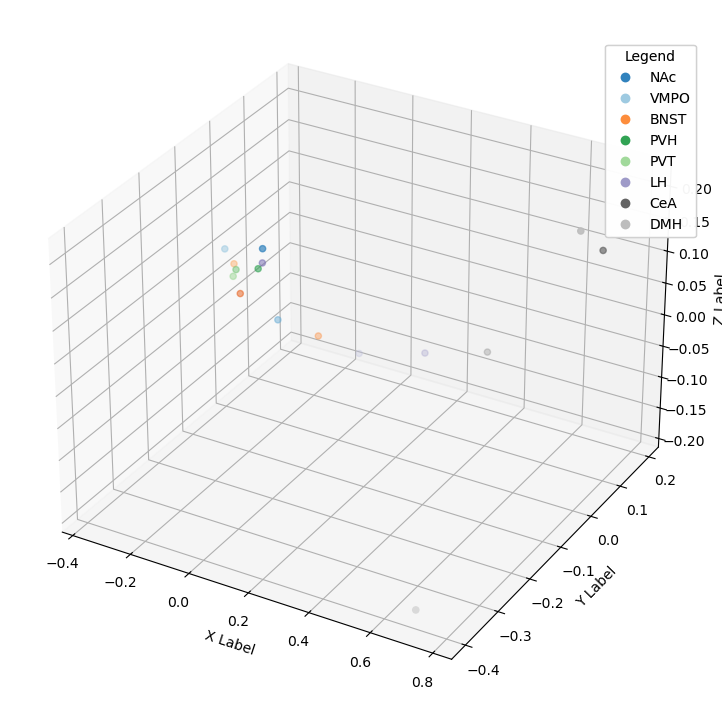

range(0, 16)


In [12]:
X_train = JSD
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(X_train ,cmap="BuPu",xticklabels=x_axis_labels,yticklabels = x_axis_labels)
fig.savefig('JSD.pdf')

pca = PCA(n_components=3)
X_PCA=pca.fit_transform(X_train)
tsne = TSNE(n_components=2,perplexity=5, random_state=24, learning_rate=5e-3)
X_100 = tsne.fit_transform(X_train)

import umap.umap_ as umap
embedding = umap.UMAP(random_state=42).fit_transform(X_train)

target= region_code_name_pool[1:end+1]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
y_lan = le.transform(target)

plt.figure(figsize=(10, 5))
ax1=plt.subplot(121)
plt.gca().set_title('PCA')
scatter=plt.scatter(X_PCA[:,0], X_PCA[:,1])
#scatter=plt.scatter(X_PCA[:,0], X_PCA[:,1],c=vectorizer(y_train),label=color)
ax2=plt.subplot(122)
plt.gca().set_title('tSNE')
plt.scatter(X_100[:,0], X_100[:,1])
#plt.scatter(X_100[:,0], X_100[:,1],c=vectorizer(y_train),label=y_train)
plt.figure(figsize=(10,16))


fig, ax = plt.subplots(figsize =(5,5))
ax1 =sns.scatterplot(
    x=X_PCA[:,0], y= X_PCA[:,2],
    hue=target,
    style=target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
np.random.seed(19680801)
fig, ax2 = plt.subplots(figsize =(5,5))
ax2 =sns.scatterplot(
    x=X_100[:,0], y= X_100[:,1],
    hue=target,
    style=target,
    legend="brief",
    alpha=1,
    palette='coolwarm'
)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()
fig.savefig('tsne.pdf')

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(projection='3d')

n = 100

scatter1 = ax.scatter(X_PCA[:,0], X_PCA[:,1],X_PCA[:,2],c=range(end),cmap='tab20c')
legend1 = ax.legend(*[scatter1.legend_elements()[0],target], 
                    title="Legend", loc='best', bbox_to_anchor=(1,0.96) ,ncol=1)
ax.add_artist(legend1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.savefig('pca3d.svg')
plt.show()

from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale
print(range(end))
colors_ = list(range(1,end+1))
discrete_colors = sample_colorscale('Bluered', minmax_scale(colors_))

# colors_ = 5 numbers you are trying to depict with the colorscale
# discrete_colors - list of 5 rgb-coded colors from *Bluered* colorscale
# minmax_scale is used because *sample colors* can only deal with floats from [0,1]

import plotly.express as px

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_PCA,
    labels=labels,
    dimensions=range(3),
    color=target,color_discrete_sequence=discrete_colors
)
fig.update_layout(template='plotly_white')
# fig.update_layout(
#     xaxis=dict(showgrid=True),
#     yaxis=dict(showgrid=True)
# )
# fig.update_layout(
#     plot_bgcolor='white'
# )
# fig.update_xaxes(
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )
# fig.update_yaxes(
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )
fig.update_traces(diagonal_visible=False)
fig.show()
fig.write_image("PCA3view.svg")

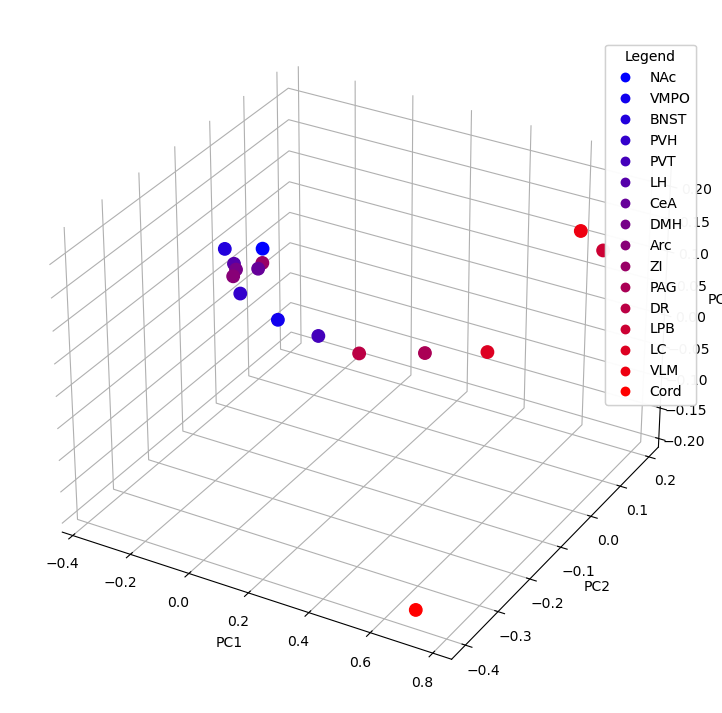

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: blue → purple → red
n_colors = end  # number of discrete categories
colors = ["blue", "purple", "red"]
rdcmap = LinearSegmentedColormap.from_list("blue_purple_red", colors, N=n_colors)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(projection='3d')

# Set white background
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Keep grid lines but remove pane shading
ax.xaxis.pane.set_facecolor('white')
ax.yaxis.pane.set_facecolor('white')
ax.zaxis.pane.set_facecolor('white')

# Optional: also remove pane edge color so no box outline
ax.xaxis.pane.set_edgecolor('white')
ax.yaxis.pane.set_edgecolor('white')
ax.zaxis.pane.set_edgecolor('white')

# Larger points
scatter1 = ax.scatter(
    X_PCA[:, 0], X_PCA[:, 1], X_PCA[:, 2],
    c=range(end), cmap=rdcmap, s=80,alpha=1.0
)

# Legend
handles, _ = scatter1.legend_elements(prop="colors", num=end)  # show all bins
legend1 = ax.legend(handles, x_axis_labels,
                    title="Legend", loc='best', bbox_to_anchor=(1, 0.96), ncol=1)
ax.add_artist(legend1)

# Labels and view
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
#ax.view_init(elev=20, azim=-80)

# Save as SVG with white background
fig.savefig('Figure2E_pca3d.svg', facecolor='white')

plt.show()

In [14]:
import pandas as pd
import numpy as np

# Assuming you have a fitted PCA object named 'pca'
# If not, and X_PCA already exists, you'll need to store explained variance manually
explained_variance = pca.explained_variance_ratio_[:3] * 100  # first 3 PCs in %

# Create a DataFrame for PCA source data
pca_df = pd.DataFrame({
    "PC1": X_PCA[:, 0],
    "PC2": X_PCA[:, 1],
    "PC3": X_PCA[:, 2],
    "Group": [x_axis_labels[i] for i in range(end)]
})

# Save coordinates to CSV
pca_df.to_csv("Figure2E_pca3d_source_data.csv", index=False)

# Save variance explained separately
var_df = pd.DataFrame({
    "PC": ["PC1", "PC2", "PC3"],
    "Variance_Explained_Percent": explained_variance
})
var_df.to_csv("Figure2E_pca3d_variance_explained.csv", index=False)


## 1.7 Motif analysis

### 1.7.1 if P(A|B)=P(A)

### 17.2-1 Motif analysis 2-1 (selected)

In [15]:
import math


B1B2_pool = combine_B1_extract
motif_candidate = ['BNST','PVH','PVT','LH','CeA','LPB','VLM']
#motif_candidate = ['BNST-Ipsi','PVH','DMH','ZI-Ipsi','ZI-Contra','VPM-Contra','PAG','LPB-Ipsi','LPB-Contra','LH-Ipsi', 'LC-Ipsi','VLM-Ipsi','NTS-Contra','Cord']
#motif_index = [region_code_index_pool.index(i) for i in motif_candidate]

#motif_candidate =['NAc-Ipsi','BNST-Ipsi','BNST-Contra','VMPO and OVLT','PVH','PVT','DMH','Arc','ZI-Ipsi','ZI-Contra','LH-Ipsi','LH-Contra',\
#                'CeA-Ipsi','VPM-Contra','PAG','DR','LPB-Ipsi','LPB-Contra','LC-Ipsi','LC-Contra','VLM-Ipsi','VLM-Contra','NTS-Contra']

from scipy.optimize import fsolve
end = pool_end_index
#motif_candidate = region_code_name_pool[1:end+1]

A = np.array(region_code_name_pool)
B = np.array(motif_candidate)
motif_index = np.nonzero(B[:,None] == A)[1]

mask0 = np.logical_and(B1B2_pool[:,motif_index[0]]!=0, B1B2_pool[:,motif_index[0]] != 0)


for AA in motif_index:
    mask0 = np.logical_or(mask0, B1B2_pool[:,AA] != 0)

obs_6 = np.sum(mask0 == True ,axis = 0)
B1_motif_extract = combine_B1_extract[:,motif_index]
B1B2_pool = B1_motif_extract

barcode_count12 = np.sum(B1B2_pool != -1, axis=0)-np.sum(B1B2_pool == 0, axis=0)
obs = np.size(B1B2_pool,0)

number_per_region = barcode_count12
Ncal = np.zeros(len(motif_candidate))
import itertools
for nn in range(len(motif_candidate)):
    a = list(itertools.combinations((number_per_region),nn+1))
    for ii in range(len(a)):
        times = 1
        for tt in a[ii]:
            times = times * tt
        Ncal[nn] = Ncal[nn]+times

from scipy.optimize import fsolve
from scipy.stats import binomtest
from scipy.stats import binom
from scipy.stats import chisquare
from scipy.stats import fisher_exact


# f = lambda x:(obs-Ncal[0])* x**16 + Ncal[1]* x**15 - Ncal[2]* x**14 + Ncal[3]* x**13 - Ncal[4]* x**12 + Ncal[5]* x**11 -Ncal[6]* x**10 +Ncal[7]* x**9\
#     -Ncal[8]* x**8 + Ncal[9]* x*7- Ncal[10]* x**6 + Ncal[11]* x**5 - Ncal[12]* x**4 + Ncal[13]* x**3-Ncal[14]* x**2+Ncal[15]* x**1-Ncal[16]

f = lambda x:(obs_6-Ncal[0])* x**6 + Ncal[1]* x**5 - Ncal[2]* x**4 + Ncal[3]* x**3 - Ncal[4]* x**2 + Ncal[5]* x**1 -Ncal[6]
# f = lambda x:(obs-Ncal[0])* x**22 + Ncal[1]* x**21 - Ncal[2]* x**20 + Ncal[3]* x**19 - Ncal[4]* x**18 + Ncal[5]* x**17\
#     -Ncal[6]* x**1 + Ncal[7]* x**15- Ncal[8]* x**14 + Ncal[9]* x**13 - Ncal[10]* x**12 + Ncal[11]* x**11-Ncal[12]* x**10+Ncal[13]* x**9\
#     -Ncal[14]* x**8 + Ncal[15]* x*7- Ncal[16]* x**6 + Ncal[17]* x**5 - Ncal[18]* x**4 + Ncal[19]* x**3-Ncal[20]* x**2+Ncal[21]* x**1-Ncal[22]
#f = lambda x:(obs-Ncal[0])* x**4 + Ncal[1]* x**3 - Ncal[2]* x**2 + Ncal[3]* x**1 - Ncal[4]
total = int(np.round(fsolve(f,[20000])))
print(total)
print('yes')
motif_data = []
test_number_not_exclude = 0
test_number_exclude = 0
for i in range (2,4):
    if i<3:
        test_number_not_exclude += math.comb(len(motif_candidate),i)
    test_number_exclude += math.comb(len(motif_candidate),i)

pass_pval_not_exclude = 0.05/test_number_not_exclude
pass_pval_exclude = 0.05/test_number_exclude
print('Independence')
print(test_number_not_exclude)
print(pass_pval_not_exclude)
print('Biominal')
print(test_number_exclude)
print(pass_pval_exclude)
proj_prob = number_per_region/total

for nn in range(1,3):
    a = list(itertools.combinations(range(len(motif_candidate)),nn+1))
    
    for ii in range(len(a)):
        data = []

        prob_exclude = 1
        prob_exclude_string = '1'
         
        for kk in range(len(motif_candidate)):
            if  kk in a[ii]:
                prob_exclude = prob_exclude * proj_prob[kk]
                prob_exclude_string = prob_exclude_string + ' * '+ str(proj_prob[kk])
         
            else:
                prob_exclude = prob_exclude * (1-proj_prob[kk])
                prob_exclude_string = prob_exclude_string + ' * (1- '+ str(proj_prob[kk])+')'

        prob_not_exclude = 1
        prob_not_exclude_string = '1'
        name = ''
        for index in a[ii]: #calculate the probability of the motif assuming independence
            prob_not_exclude = prob_not_exclude * proj_prob[index]
            prob_not_exclude_string = prob_not_exclude_string + ' * '+str(proj_prob[index])
            if name == '':
                name = motif_candidate[index]
            else:
                name = name +'_'+ motif_candidate[index]
        #calculate the observe counts of the motifs
        data.append(nn+1)
        data.append(name)
        data.append(prob_not_exclude)
        data.append(prob_not_exclude_string)
        mask1 = B1B2_pool[:,0] >-1
        #print(mask1)
        for i in range(len(motif_candidate)):
            if i in a[ii]:
                mask_inter = B1B2_pool[:,i] != 0
                mask1 = np.logical_and(mask1 ,mask_inter)
            else:
                mask_inter = B1B2_pool[:,i] == 0
                mask1 = np.logical_and(mask1 , mask_inter)


        mask = np.logical_and(B1B2_pool[:,a[ii][0]]!=0, B1B2_pool[:,a[ii][1]] != 0)
        if nn>1:
            for cc in range(2,nn+1):
                mask = np.logical_and(mask, B1B2_pool[:,a[ii][cc]] != 0)
     
        observe_count_not_exclude = np.sum(mask == True ,axis = 0)
        data.append(observe_count_not_exclude)

        expected_count_not_exclude = prob_not_exclude*total
        expected_count_exclude = prob_exclude*total
        
        
        data.append(expected_count_not_exclude)
        if len(a[ii])==2:
            if expected_count_not_exclude <5:
                # Create a 2x2 contingency table
                counta = np.sum(B1B2_pool[:,a[ii][0]]!=0)
                countb = np.sum(B1B2_pool[:,a[ii][1]]!=0)
                t1 = observe_count_not_exclude
                t2 = counta-t1
                t3 = countb-t1
                t4 = total-t1-t2-t3
                table = [[t1, t2], [t3, t4]]

                # Perform Fisher's exact test
                oddsratio, pvalue = fisher_exact(table)
                data.append(pvalue)
                elsexpected_count_not_exclude_fisher = (t1+t3)*(t2+t4)/total
            
                if pvalue <= pass_pval_not_exclude: 
                    if expected_count_not_exclude  > observe_count_not_exclude:
                        data.append('Under')
                    elif expected_count_not_exclude < observe_count_not_exclude:
                        data.append('Over')
                    else:
                        data.append('equal')
                else:
                    data.append('n.s.')
            else:
                
                chi_stat = chisquare([observe_count_not_exclude,total-observe_count_not_exclude],f_exp=[expected_count_not_exclude ,total-expected_count_not_exclude])
                data.append(chi_stat.pvalue)
                
                if chi_stat.pvalue <= pass_pval_not_exclude:
                    if expected_count_not_exclude  > observe_count_not_exclude:
                        data.append('Under')
                    elif expected_count_not_exclude < observe_count_not_exclude:
                        data.append('Over')
                    else:
                        data.append('equal')
                else:
                    data.append('n.s.')
        else:
            data.append('NA')
            data.append('not analyzed')

        observe_count1 = np.sum(mask1 == True ,axis = 0)
        data.append(prob_exclude)
        data.append(prob_exclude_string)
        data.append(observe_count1)
        data.append(expected_count_exclude)
        if observe_count1>=0 and expected_count_exclude >=0:
            binomtest_stat_twoside = binomtest(observe_count1, total, prob_exclude,alternative = 'two-sided')
            data.append(binomtest_stat_twoside.pvalue)
            binomtest_stat_greater = binomtest(observe_count1, total, prob_exclude,alternative = 'greater')
            data.append(binomtest_stat_greater.pvalue)
            binomtest_stat_less = binomtest(observe_count1, total, prob_exclude,alternative = 'less')
            data.append(binomtest_stat_less.pvalue)
            if binomtest_stat_twoside.pvalue <= pass_pval_exclude:
                if binomtest_stat_less.pvalue < binomtest_stat_greater.pvalue:
                    data.append('Under')
                else:
                    data.append('Over')
            else:
                data.append('n.s.')
        else:
            data.append('NA')
            data.append('NA')
            data.append('NA')
            data.append('NA')
        motif_data.append(data)

df = pd.DataFrame(motif_data)
df.columns = ['Number of region','Motif','probability not exclude','formula of probability not exclude','Observe','Expected','chisquare p','chisquare conclusion','probability exclude','formula of probability exclude','Observed exclude','Expected exclude','two-sided','greater','less','binominal conclusion']
df.to_csv('20250809_2-3_selected_combined_motif_result.csv')


853
yes
Independence
21
0.002380952380952381
Biominal
56
0.0008928571428571429


/var/folders/14/3j7hb71x7tzdv5b7_7_kv4nc0000gn/T/ipykernel_94560/1100153536.py:59: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [16]:

bi_con = df['binominal conclusion']
bi_p = df['two-sided']
bi_e = df['Expected exclude']
bi_o = df['Observed exclude']
p_value_flatten = list(bi_p)
p_value_flatten.sort()

kkk=0
bi_con_hb = []
bi_hb_p =[]
print(p_value_flatten)
for ii in range(len(bi_o)):
    p_hb=0.05/(1+test_number_exclude-p_value_flatten.index(bi_p[ii]))
    if bi_p[ii] <= p_hb:
        if bi_e[ii]  > bi_o[ii]:
            bi_con_hb.append('Under')
        elif bi_e[ii] < bi_o[ii]:
            bi_con_hb.append('Over')
    else:
        bi_con_hb.append('n.s.')
    bi_hb_p.append(p_hb)

df['binominal_hb_con'] = bi_con_hb
df['binominal_hb_p'] = bi_hb_p
df.to_csv('202500809_2-3_hbselect_combined_motif_result.csv')



[4.529092042009386e-09, 5.715540450674774e-09, 3.904348585099328e-07, 7.058735096787811e-06, 9.994994130173972e-05, 0.00034648927196832043, 0.000403992663227821, 0.0005847513551239981, 0.0015513026491256708, 0.003109431940547406, 0.003655073667449125, 0.00391948672602817, 0.0040512071982551435, 0.008951260599093177, 0.011894602999131376, 0.012397840481384982, 0.012402997008947253, 0.03241336706856486, 0.0391540557113032, 0.04036595552419872, 0.056017039498312826, 0.07022956493983987, 0.08741009668549908, 0.10869905873342044, 0.19916322764051386, 0.27252723629861375, 0.3014081185292981, 0.33017421933151575, 0.39818838480824836, 0.48405994849279244, 0.5352766504061284, 0.5577743090884664, 0.640315014759085, 0.6660210198225268, 0.692911704555302, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### 17.3 Motif analysis plot

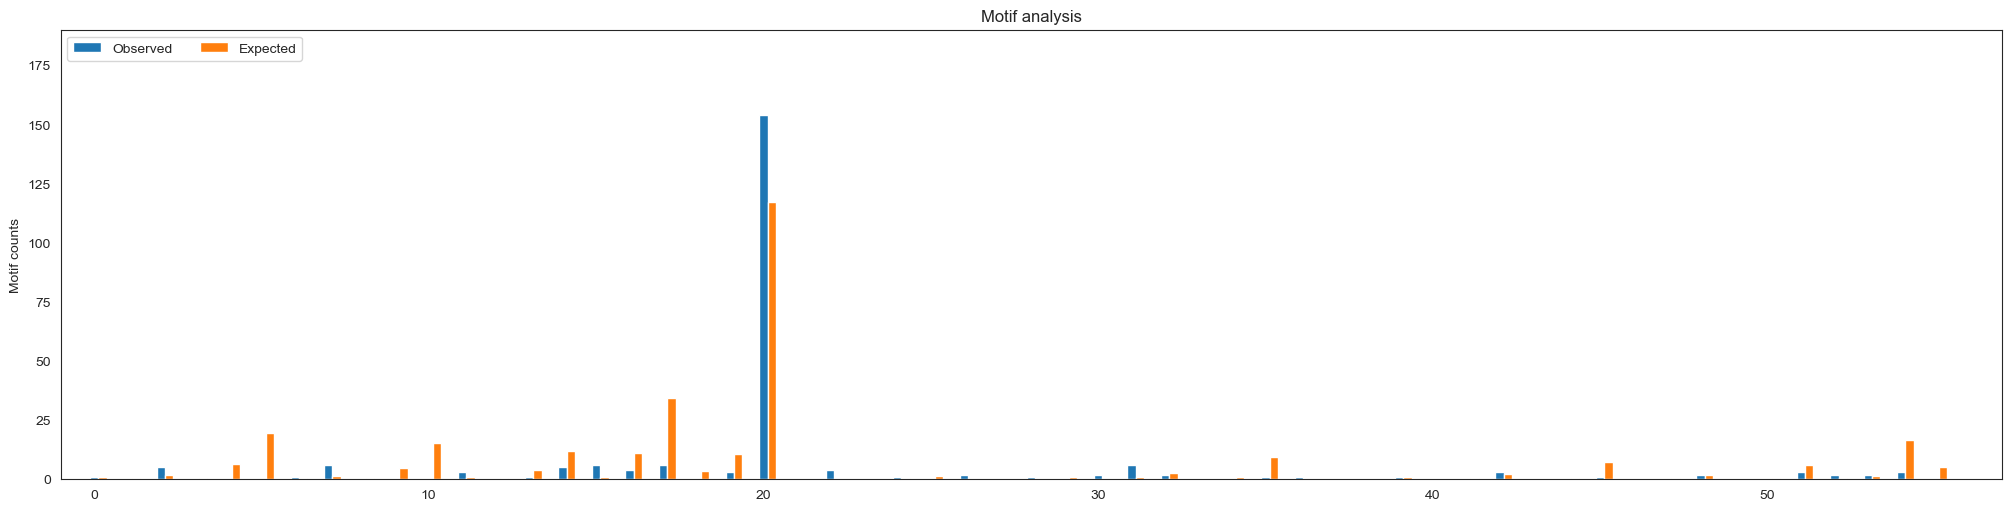

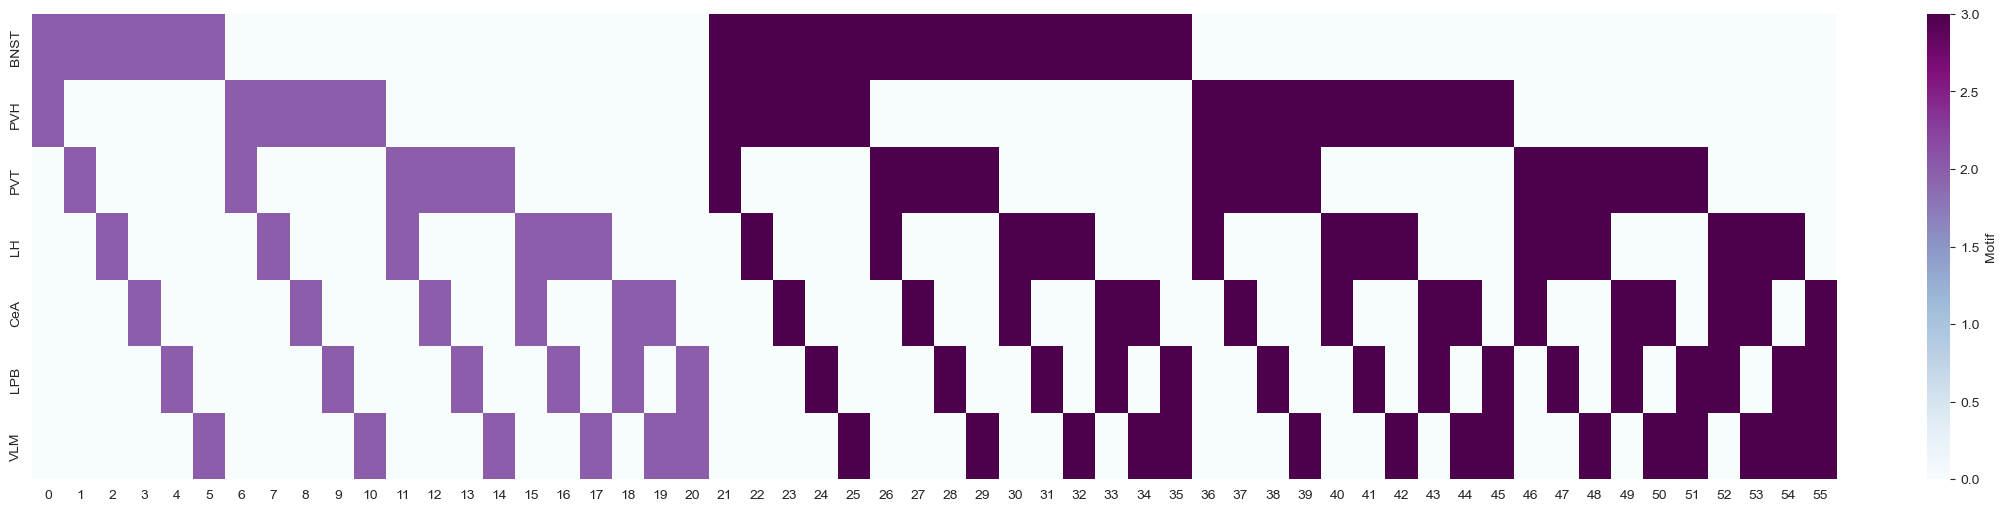

In [17]:
sns.set_style("white") 
filter_index_mask = np.logical_or(df['Observed exclude']>=0,df['Expected exclude']>=0)
filter_index = np.where(filter_index_mask==True)[0]

motif_counts = df['Observed exclude'][filter_index]
motif_expected = df['Expected exclude'][filter_index]
import matplotlib.pyplot as plt
import numpy as np

motif_name = df['Motif'][filter_index]

motif_analysis= {
    'Observed': motif_counts,
    'Expected': motif_expected,
}

x = np.arange(len(motif_name))  # the label locations

width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained',figsize = (20, 5))

for attribute, measurement in motif_analysis.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Motif counts')
ax.set_title('Motif analysis')
#ax.set_xticks(x + width)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 190)
ax.set_xlim(-1, len(filter_index)+1)
plt.show()
fig.savefig('20250809_motif_counts.pdf')

fig, ax = plt.subplots(layout='constrained',figsize = (20, 5))
motif_matrix = np.zeros([len(motif_candidate),len(filter_index)])
k=0
for i in filter_index:
    curr_comb = motif_name[i]
    comb_list = curr_comb.split("_")
    for j in comb_list:
       ccidx=motif_candidate.index(j)
       motif_matrix[ccidx,k]=len(comb_list)
    k = k+1
y_axis_labels = motif_candidate
sns.heatmap(motif_matrix,cmap='BuPu',yticklabels = y_axis_labels,cbar_kws={'label': 'Motif'})
plt.show()
fig.savefig('20250809_motif_matrix.pdf')


##### Upset plot


/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/Users/charlotte/anaconda3/envs/lab-analysis/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

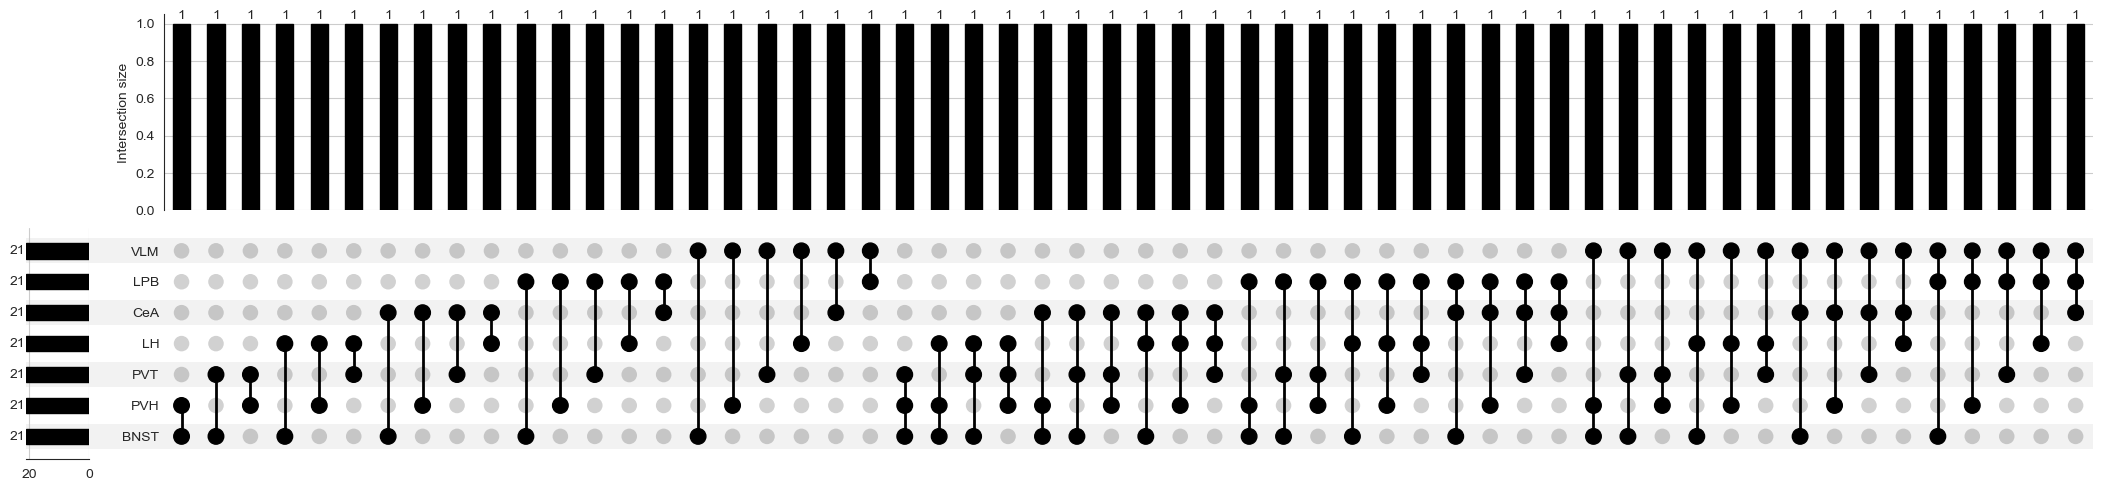

/var/folders/14/3j7hb71x7tzdv5b7_7_kv4nc0000gn/T/ipykernel_94560/1238374057.py:35: UserWarning:

There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword



In [18]:
from upsetplot import UpSet, from_indicators
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['svg.fonttype'] = 'none'

# Build a binary presence matrix: rows = motifs, cols = combinations (filter_index)
motif_matrix = np.zeros((len(motif_candidate), len(filter_index)), dtype=int)

for k, i in enumerate(filter_index):
    comb_list = motif_name[i].split("_")
    for j in comb_list:
        ccidx = motif_candidate.index(j)  # make sure j is in motif_candidate
        motif_matrix[ccidx, k] = 1        # 1 = present

# Make DataFrame
y_axis_labels = motif_candidate                # motif names
comb_labels = [f"comb_{k+1}" for k in range(len(filter_index))]  # optional column names
motif_df = pd.DataFrame(motif_matrix, index=y_axis_labels, columns=comb_labels)

# UpSet needs columns as indicators; transpose so columns = motifs
motif_bool = motif_df.T.astype(bool)          # shape: (combinations, motifs)

# Create UpSet data (indicators are motif names = columns of motif_bool)
motif_sets = from_indicators(motif_bool.columns, motif_bool)

# Plot
fig = plt.figure(figsize=(12, 6), layout='constrained')
UpSet(motif_sets, show_counts=True, orientation='horizontal').plot(fig=fig)
plt.show()

# Optional: save vector output
fig.savefig("Figure2F_bottom_motif_upset.svg")

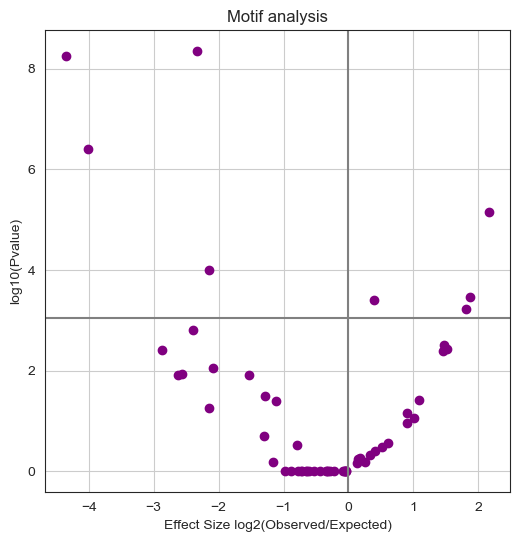

In [19]:

motif_counts = df['Observed exclude']
motif_expected = df['Expected exclude']
motif_p = df['two-sided']
yy = -np.log10(motif_p)
xx=np.log2((motif_counts+1)/(motif_expected+1))
#xx1=np.log2((motif_counts+1)/(motif_expected+1))
#xx = (motif_counts-motif_expected)/motif_expected
#xx = abs(motif_counts-motif_expected)*(motif_counts-motif_expected)/(motif_expected)
# fig, ax = plt.subplots(figsize =(5,5))
# ax1 =sns.scatterplot(
#     x=xx, y= yy,
#     legend="brief",
#     alpha=1,
#     palette='icefire'
# )
# # Calculate the line of best fit using NumPy's polyfit
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_style("whitegrid")
#ax.plot(xx1,yy,'o',color='yellow')
ax.plot(xx,yy,'o',color='purple')

ax.set(xlabel="Effect Size log2(Observed/Expected)", ylabel="log10(Pvalue)",
       title="Motif analysis")
# Plot the line

plt.axhline(y=-np.log10(pass_pval_exclude), color='grey')
plt.axvline(x=0, color='grey')
plt.grid(True)
plt.show()
fig.savefig('Figure2G_2-3_select_volcano.svg')
#print(xx)
#print(xx1)

In [20]:
import pandas as pd

# Create DataFrame
volcano_df = pd.DataFrame({
    "Motif": df['Motif'],                 # assuming df has 'Motif' column
    "Observed": motif_counts,
    "Expected": motif_expected,
    "P_value": motif_p,
    "log2_EffectSize": xx,
    "neg_log10_Pvalue": yy
})

# Save to CSV
volcano_df.to_csv("Figure2G_volcano_plot_data.csv", index=False)